<a href="https://colab.research.google.com/github/FaisalWani123/DND/blob/main/LQG50M_DNDV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.



## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;


## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

**NEPTUN CODE: LQG50M**

**NAME: FAISAL WANI**

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [ ]:
# Fix to work on colab
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
# ADD YOUR CODE HERE
import torch

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

In [ ]:
!unzip flickr8k.zip -d flickr8k

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from collections import Counter
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') # Download punkt_tab data package

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.word_tokenize(text.lower())

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = len(self.itos)

        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

            for token in tokens:
                if frequencies[token] >= self.freq_threshold and token not in self.stoi:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.transform = transform

        # Read captions file and parse data
        self.imgs = []
        self.captions = []

        with open(captions_file, 'r') as f:
            lines = f.readlines()

        # Skip the header line (first line)
        for line in lines[1:]:  # Start from the second line
            # Split on first comma
            img_caption_pair = line.strip().split(',', 1)

            # Ensure we have both image name and caption
            if len(img_caption_pair) == 2:
                img, caption = img_caption_pair
                self.imgs.append(img.strip())      # Add cleaned image name
                self.captions.append(caption.strip())  # Add cleaned caption
            else:
                print(f"Skipping invalid line: {line}")

        # Initialize vocabulary and build it
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions)

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imgs[idx])
        caption = self.captions[idx]

        # Load image
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image not found: {img_name}")

        img = Image.open(img_name).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Convert caption to numericalized vector with special tokens
        caption_vec = [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(caption_vec)

In [ ]:
with open("/content/flickr8k/captions.txt", 'r') as f:
    lines = f.readlines()
    print(lines[:5])  # Print first 5 lines for inspection

In [ ]:
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize dataset
dataset = FlickrDataset(
    root_dir="/content/flickr8k/Images",       # Path to images folder
    captions_file="/content/flickr8k/captions.txt",
    transform=transform,
    freq_threshold=5,
)

# Test dataset functionality
img, caps = dataset[0]
print("Image:", img)
print("Caption Tokens:", caps)
decoded_sentence = [dataset.vocab.itos[token] for token in caps.tolist()]
print("Decoded Sentence:", " ".join(decoded_sentence))

Example output from dataset class

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to display an image
def show_image(image, title=None):
    # Convert tensor to numpy and transpose to (H, W, C) for displaying
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Example usage with the dataset
img, caps = dataset[0]  # Get the first example from the dataset

# Show the image
show_image(img, "Sample Image")

# Print the tokenized caption
print("Tokenized Caption:", caps)

# Decode and print the sentence
decoded_sentence = [dataset.vocab.itos[token] for token in caps.tolist()]
print("Decoded Sentence:", " ".join(decoded_sentence))

Split your dataset into train, val and test sets

In [ ]:
# ADD YOUR CODE HERE
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print dataset sizes to verify
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Create a dataloader, in order to load the examples in batches. Remember that, a batch has different examples, and each example (caption) may have different sizes. Therefore, consider padding techniques for the captions. For the image, use transforms in the previous step, to ensure same format and size.  

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_fn(batch):
    """
    Custom collate function to handle variable-length captions.
    Args:
        batch: List of tuples (image, caption).
    Returns:
        images: Tensor of shape [batch_size, 3, H, W].
        captions: Padded tensor of shape [batch_size, max_caption_length].
    """
    images = []
    captions = []

    for img, caption in batch:
        images.append(img)  # Add image tensor
        captions.append(caption)  # Add caption tensor

    # Stack images into a single tensor
    images = torch.stack(images)

    # Pad captions to the maximum length in the batch
    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    return images, captions

In [ ]:
# Define batch size
batch_size = 32
# batch_size = 6

# Create DataLoaders for train, val, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Fetch a single batch from train_loader
images_batch, captions_batch = next(iter(train_loader))

print("Image Batch Shape:", images_batch.shape)  # Expected: [batch_size, 3, H, W]
print("Captions Batch Shape:", captions_batch.shape)  # Expected: [batch_size, max_caption_length]

# Decode one example caption from the batch
example_caption = captions_batch[0]
decoded_caption = [dataset.vocab.itos[token.item()] for token in example_caption if token.item() != 0]
print("Decoded Caption:", " ".join(decoded_caption))

#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [ ]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Updated for PyTorch >= 0.13
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC layer and pooling

    def forward(self, images):
        """
        Forward pass for the encoder.
        Args:
            images: Input images of shape [batch_size, 3, H, W].
        Returns:
            features: Flattened feature map of shape [batch_size, num_pixels, encoder_dim].
        """
        features = self.resnet(images)  # Shape: [batch_size, 2048, H/32, W/32]
        features = features.permute(0, 2, 3, 1)  # Shape: [batch_size, H/32, W/32, encoder_dim]
        features = features.view(features.size(0), -1, features.size(-1))  # Flatten spatial dimensions
        return features  # Shape: [batch_size, num_pixels (H*W), encoder_dim]

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # Transform encoder features
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # Transform decoder hidden state
        self.full_att = nn.Linear(attention_dim, 1)              # Compute attention scores
        self.softmax = nn.Softmax(dim=1)                         # Normalize scores

    def forward(self, features, hidden_state):
        """
        Args:
            features: [batch_size, num_pixels, encoder_dim]
            hidden_state: [batch_size, decoder_dim]
        Returns:
            context: [batch_size, encoder_dim]
            weights: [batch_size, num_pixels]
        """
        # Transform inputs
        encoder_att = self.encoder_att(features)                 # Shape: [batch_size, num_pixels, attention_dim]
        decoder_att = self.decoder_att(hidden_state).unsqueeze(1)  # Shape: [batch_size, 1, attention_dim]

        # Compute attention scores
        att_scores = self.full_att(torch.tanh(encoder_att + decoder_att))  # Shape: [batch_size, num_pixels, 1]
        weights = self.softmax(att_scores.squeeze(2))                      # Shape: [batch_size, num_pixels]

        # Compute context vector as weighted sum of features
        context = torch.sum(weights.unsqueeze(2) * features, dim=1)       # Shape: [batch_size, encoder_dim]

        return context, weights

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim):
        """
        Decoder with Attention for Image Captioning.
        Args:
            embed_size: Dimension of word embeddings.
            vocab_size: Size of the vocabulary.
            attention_dim: Dimension of the attention layer.
            encoder_dim: Dimension of the encoder's output feature map.
            decoder_dim: Dimension of the decoder's hidden state.
        """
        super(Decoder, self).__init__()

        # Attention layer
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        # Embedding layer for captions
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM for decoding
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, decoder_dim)

        # Fully connected layer to generate vocabulary scores
        self.fc = nn.Linear(decoder_dim, vocab_size)

        # Linear layer to initialize LSTM hidden state
        self.init_h = nn.Linear(encoder_dim, decoder_dim)

        # Linear layer to initialize LSTM cell state
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    def init_hidden_state(self, features):
        """
        Initialize the hidden and cell states of the LSTM.
        Args:
            features: Encoder output feature map of shape [batch_size, encoder_dim].
        Returns:
            h: Initialized hidden state of shape [batch_size, decoder_dim].
            c: Initialized cell state of shape [batch_size, decoder_dim].
        """
        h = torch.tanh(self.init_h(features.mean(dim=1)))  # Mean pooling over spatial dimensions
        c = torch.tanh(self.init_c(features.mean(dim=1)))
        return h, c

    def forward(self, features, captions):
        """
        Forward pass for the decoder.
        Args:
            features: Encoder output feature map of shape [batch_size, num_pixels, encoder_dim].
            captions: Ground truth captions of shape [batch_size, max_caption_length].
        Returns:
            predictions: Vocabulary scores for each time step [batch_size, max_caption_length, vocab_size].
            alphas: Attention weights for each time step [batch_size, max_caption_length, num_pixels].
        """
        batch_size = features.size(0)
        num_pixels = features.size(1)

        # Embed captions (excluding <EOS> token for teacher forcing)
        embeddings = self.embedding(captions)  # Shape: [batch_size, max_caption_length, embed_size]

        # Initialize LSTM hidden and cell states
        h, c = self.init_hidden_state(features)  # Shape: [batch_size, decoder_dim]

        predictions = []
        alphas = []

        for t in range(captions.size(1) - 1):  # Iterate over time steps (excluding <EOS>)
            # Compute attention context and weights
            context, alpha = self.attention(features, h)  # Shape: [batch_size, encoder_dim], [batch_size, num_pixels]

            # Concatenate embedding and context vector
            lstm_input = torch.cat((embeddings[:, t], context), dim=1)  # Shape: [batch_size, embed_size + encoder_dim]

            # Pass through LSTM
            h, c = self.lstm(lstm_input, (h, c))  # Shape: [batch_size, decoder_dim]

            # Apply dropout and fully connected layer to get vocabulary scores
            preds = self.fc(self.dropout(h))  # Shape: [batch_size, vocab_size]

            predictions.append(preds)
            alphas.append(alpha)

        predictions = torch.stack(predictions, dim=1)  # Shape: [batch_size, max_caption_length - 1, vocab_size]
        alphas = torch.stack(alphas, dim=1)  # Shape: [batch_size, max_caption_length - 1, num_pixels]

        return predictions, alphas

Combine the encoder - attention - decoder

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim):
        """
        Combines Encoder, Attention, and Decoder into a single model.
        Args:
            embed_size: Dimension of word embeddings.
            vocab_size: Size of the vocabulary.
            attention_dim: Dimension of the attention layer.
            encoder_dim: Dimension of the encoder's output feature map.
            decoder_dim: Dimension of the decoder's hidden state.
        """
        super(ImageCaptioningModel, self).__init__()

        # Initialize Encoder
        self.encoder = Encoder()

        # Initialize Decoder
        self.decoder = Decoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim)

    def forward(self, images, captions):
        """
        Forward pass for the combined model.
        Args:
            images: Input images of shape [batch_size, 3, H, W].
            captions: Ground truth captions of shape [batch_size, max_caption_length].
        Returns:
            predictions: Vocabulary scores for each time step [batch_size, max_caption_length - 1, vocab_size].
            alphas: Attention weights for each time step [batch_size, max_caption_length - 1, num_pixels].
        """
        # Pass images through the encoder to extract features
        features = self.encoder(images)  # Shape: [batch_size, num_pixels, encoder_dim]

        # Pass features and captions through the decoder
        predictions, alphas = self.decoder(features, captions)

        return predictions, alphas

### 2.2. Training custom model

### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

In [ ]:
import torch.optim as optim
from tqdm import tqdm
# Define training function
def train_model(model, train_loader, val_loader, vocab_size, device, num_epochs=10, learning_rate=1e-4):
    """
    Train the custom image captioning model.
    Args:
        model: The ImageCaptioningModel instance.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        vocab_size: Size of the vocabulary.
        device: Device to run the training on (CPU/GPU).
        num_epochs: Number of epochs to train.
        learning_rate: Learning rate for optimizer.
    Returns:
        train_losses: List of training losses per epoch.
        val_losses: List of validation losses per epoch.
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to device
    model = model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0

        for images, captions in tqdm(train_loader):
            images, captions = images.to(device), captions.to(device)

            # Forward pass
            optimizer.zero_grad()
            predictions, _ = model(images, captions)

            # Reshape predictions and targets for loss calculation
            predictions = predictions.view(-1, vocab_size)  # [batch_size * seq_len, vocab_size]
            targets = captions[:, 1:].reshape(-1)           # [batch_size * seq_len]

            # Compute loss
            loss = criterion(predictions, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)

                # Forward pass
                predictions, _ = model(images, captions)

                # Reshape predictions and targets for loss calculation
                predictions = predictions.view(-1, vocab_size)
                targets = captions[:, 1:].reshape(-1)

                # Compute loss
                loss = criterion(predictions, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


    return train_losses, val_losses

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

In [ ]:
import matplotlib.pyplot as plt

# Define hyperparameters
embed_size = 256
vocab_size = len(dataset.vocab)  # Vocabulary size from your dataset
attention_dim = 256
encoder_dim = 2048  # ResNet50 output dimension
decoder_dim = 512
num_epochs = 3 #Should be 10
learning_rate = 1e-4

# Initialize model
model = ImageCaptioningModel(embed_size=embed_size,
                             vocab_size=vocab_size,
                             attention_dim=attention_dim,
                             encoder_dim=encoder_dim,
                             decoder_dim=decoder_dim).to(device)

# Train the model
train_losses, val_losses = train_model(model=model,
                                       train_loader=train_loader,
                                       val_loader=val_loader,
                                       vocab_size=vocab_size,
                                       device=device,
                                       num_epochs=3,
                                       learning_rate=1e-4)
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.show()

# Plot training and validation losses
plot_losses(train_losses, val_losses)

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def visualize_attention(image_path, model, vocab, device):
    """
    Visualize attention weights for a given image and generated caption.
    Args:
        image_path: Path to the input image.
        model: Trained ImageCaptioningModel instance.
        vocab: Vocabulary object (to convert tokens to words).
        device: Device (CPU/GPU) to run inference on.
    """
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    input_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Generate caption and attention weights
    model.eval()
    with torch.no_grad():
        features = model.encoder(input_image)  # Extract features using encoder
        caption = [vocab.stoi["<SOS>"]]
        alphas = []  # Store attention weights

        hidden_state, cell_state = model.decoder.init_hidden_state(features)

        for _ in range(20):  # Generate up to 20 words (or until <EOS>)
            embedded_word = model.decoder.embedding(torch.tensor([caption[-1]]).to(device))
            context, alpha = model.decoder.attention(features, hidden_state)
            lstm_input = torch.cat((embedded_word, context), dim=1)
            hidden_state, cell_state = model.decoder.lstm(lstm_input, (hidden_state, cell_state))
            output = model.decoder.fc(hidden_state)

            predicted_word_idx = output.argmax(1).item()
            caption.append(predicted_word_idx)
            alphas.append(alpha.cpu().squeeze(0).numpy())

            if predicted_word_idx == vocab.stoi["<EOS>"]:
                break

    # Convert caption tokens to words
    caption_words = [vocab.itos[idx] for idx in caption]

    # Plot image and attention maps
    fig, axes = plt.subplots(nrows=1, ncols=len(caption_words), figsize=(20, 10))
    for i in range(len(caption_words)):
        ax = axes[i]
        ax.imshow(image)

        if i < len(alphas):
            alpha_resized = np.array(Image.fromarray(alphas[i]).resize((224, 224)))
            ax.imshow(alpha_resized, cmap="jet", alpha=0.6)  # Overlay heatmap

        ax.set_title(caption_words[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

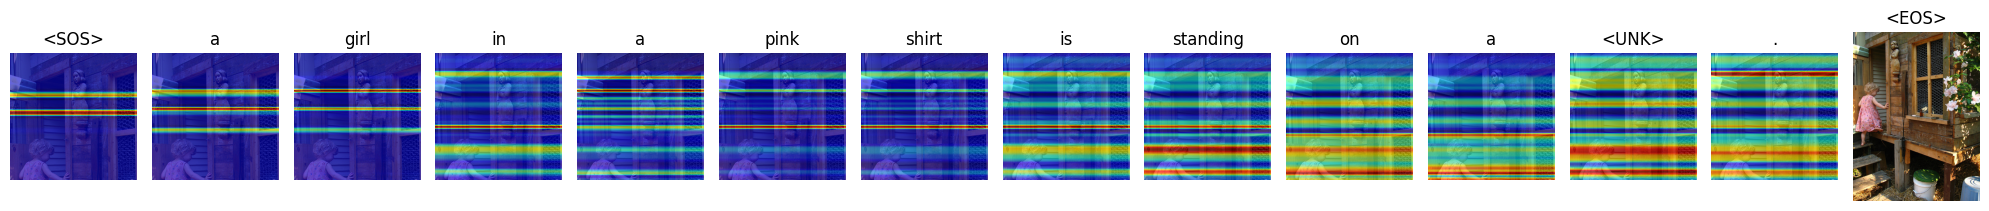

In [ ]:
# Path to an example image from your dataset
image_path = "flickr8k/Images/1000268201_693b08cb0e.jpg"

# Visualize attention weights
visualize_attention(image_path=image_path,
                    model=model,
                    vocab=dataset.vocab,
                    device=device)

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [ ]:
from torchtext.data.metrics import bleu_score
def evaluate_model(model, test_loader, vocab, device):
    """
    Evaluate the trained model on the test set using BLEU scores.
    """
    model.eval()
    references = []  # List of ground truth captions
    hypotheses = []  # List of generated captions

    with torch.no_grad():
        for images, captions in test_loader:
            images = images.to(device)
            batch_size = images.size(0)

            # Generate captions for each image in the batch
            for i in range(batch_size):
                # Extract features using encoder
                features = model.encoder(images[i].unsqueeze(0))  # Shape: [1, num_pixels, encoder_dim]

                # Generate caption using decoder
                generated_caption = []
                hidden_state, cell_state = model.decoder.init_hidden_state(features)
                word_idx = vocab.stoi["<SOS>"]  # Start with <SOS> token

                for _ in range(20):  # Generate up to 20 words or until <EOS>
                    embedded_word = model.decoder.embedding(torch.tensor([word_idx]).to(device))
                    context, _ = model.decoder.attention(features, hidden_state)
                    lstm_input = torch.cat((embedded_word, context), dim=1)
                    hidden_state, cell_state = model.decoder.lstm(lstm_input, (hidden_state, cell_state))
                    output = model.decoder.fc(hidden_state)
                    word_idx = output.argmax(1).item()
                    if word_idx == vocab.stoi["<EOS>"]:
                        break
                    generated_caption.append(word_idx)

                # Convert generated tokens to words
                hypotheses.append([vocab.itos[idx] for idx in generated_caption])

                # Convert ground truth caption(s) to words (single reference per image)
                reference_caption = captions[i].tolist()  # Single caption for this image
                reference_caption_words = [vocab.itos[idx] for idx in reference_caption if idx not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}]
                references.append([reference_caption_words])  # Wrap in a list for BLEU score compatibility

    # Compute BLEU scores
    bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[0.33, 0.33, 0.33])

    return bleu1, bleu2, bleu3

In [ ]:
# Evaluate the model on the test set
Mybleu1, Mybleu2, Mybleu3 = evaluate_model(model=model,
                                     test_loader=test_loader,
                                     vocab=dataset.vocab,
                                     device=device)

print(f"BLEU-1 Score: {Mybleu1:.4f}")
print(f"BLEU-2 Score: {Mybleu2:.4f}")
print(f"BLEU-3 Score: {Mybleu3:.4f}")

### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [ ]:
pip install transformers

In [ ]:
import matplotlib.pyplot as plt
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from PIL import Image

# Function to generate caption and display image
def generate_caption_with_image(image_path, model, feature_extractor, tokenizer, device):
    """
    Generate a caption for an image and display the image with the caption.
    Args:
        image_path (str): Path to the input image.
        model: Pre-trained VisionEncoderDecoderModel.
        feature_extractor: Feature extractor for the encoder.
        tokenizer: Tokenizer for the decoder.
        device: Device to run inference on (CPU/GPU).
    Returns:
        str: Generated caption.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate caption
    output_ids = model.generate(pixel_values, max_length=20, num_beams=4)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Display the image with the caption
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption, fontsize=16, wrap=True)
    plt.show()

    return caption

In [ ]:
# Load pre-trained model and utilities
model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move model to device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Path to an example image
image_path = "flickr8k/Images/1000268201_693b08cb0e.jpg"  # Replace with your test image path

# Generate caption and display image
caption = generate_caption_with_image(image_path, model, feature_extractor, tokenizer, device)
print(f"Generated Caption: {caption}")

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [ ]:
from torchtext.data.metrics import bleu_score

def evaluate_pretrained_model(model, feature_extractor, tokenizer, test_loader, vocab, device):
    """
    Evaluate a pre-trained image captioning model on the test set using BLEU scores.
    Args:
        model: Pre-trained VisionEncoderDecoderModel.
        feature_extractor: Feature extractor for the encoder.
        tokenizer: Tokenizer for the decoder.
        test_loader: DataLoader for the test set.
        vocab: Vocabulary object (to convert tokens to words).
        device: Device (CPU/GPU) to run inference on.
    Returns:
        bleu1: BLEU-1 score (unigrams).
        bleu2: BLEU-2 score (bigrams).
        bleu3: BLEU-3 score (trigrams).
    """
    model.eval()
    references = []  # List of ground truth captions
    hypotheses = []  # List of generated captions

    with torch.no_grad():
        for images, captions in test_loader:
            images = images.to(device)
            batch_size = images.size(0)

            # Generate captions for each image in the batch
            for i in range(batch_size):
                # Preprocess and extract features
                image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to PIL-compatible format
                pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

                # Generate caption
                output_ids = model.generate(pixel_values, max_length=20, num_beams=4)
                generated_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
                hypotheses.append(generated_caption.split())  # Tokenize generated caption

                # Convert ground truth caption(s) to words
                reference_caption = captions[i].tolist()  # Single caption for this image
                reference_caption_words = [vocab.itos[idx] for idx in reference_caption if idx not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}]
                references.append([reference_caption_words])  # Wrap in a list for BLEU compatibility

    # Compute BLEU scores
    bleu1 = bleu_score(hypotheses, references, max_n=1, weights=[1.0])
    bleu2 = bleu_score(hypotheses, references, max_n=2, weights=[0.5, 0.5])
    bleu3 = bleu_score(hypotheses, references, max_n=3, weights=[0.33, 0.33, 0.33])

    return bleu1, bleu2, bleu3

In [ ]:
# Evaluate pre-trained model on the test set
bleu1, bleu2, bleu3 = evaluate_pretrained_model(model=model,
                                                feature_extractor=feature_extractor,
                                                tokenizer=tokenizer,
                                                test_loader=test_loader,
                                                vocab=dataset.vocab,
                                                device=device)

print(f"Pre-Trained Model BLEU-1 Score: {bleu1:.4f}")
print(f"Pre-Trained Model BLEU-2 Score: {bleu2:.4f}")
print(f"Pre-Trained Model BLEU-3 Score: {bleu3:.4f}")

# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

In [ ]:
print("These are the pretrained model scores", bleu1, bleu2, bleu3)

In [ ]:
print("These are my model's scores", Mybleu1, Mybleu2, Mybleu3)

In [ ]:
import matplotlib.pyplot as plt

# Data for pretrained and custom model BLEU scores
pretrained_scores = [bleu1, bleu2, bleu3]
my_scores = [Mybleu1, Mybleu2, Mybleu3]
names = ['BLEU 1', 'BLEU 2', 'BLEU 3']

# Create bar chart
x = range(len(names))

plt.bar(x, pretrained_scores, width=0.4, label='Pretrained Model', color='b', align='center')
plt.bar([p + 0.4 for p in x], my_scores, width=0.4, label='My Model', color='r', align='center')

plt.xlabel('BLEU Scores')
plt.ylabel('Scores')
plt.title('Comparison of BLEU Scores')
plt.xticks([p + 0.2 for p in x], names)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


From the above comparison, we can see that my model performs better in all three BLEU scores, especially in BLEU2 and BLEU3 scores.

***Reasons for the difference. ***

1) The pre-trained model (nlpconnect/vit-gpt2-image-captioning) might have a limited vocabulary or struggle to understand broader context in images, resulting in simple, generic captions that don't capture nuanced details.

In summary, BLEU-1 only considers individual words (unigrams), while BLEU-2 and BLEU-3 look at sequences of two and three words respectively.
As n increases, it becomes more challenging for the model to match longer word sequences with the reference captions, naturally leading to lower scores.

Although both models show a decrease in scores as the word sequencing increases, my model shows a more steady decline, whereas the pretrained model shows a sharp and major decline.

My custom model can be improved by adding more epochs, as my model only was trained in 3 epochs and still performs well, setting the epochs to 10 can be a valid next step. This can also be paired with decreasing the batch size to 16 to see if the model converges faster due to the faster parameter updates. However, an increase in epochs and a decrease in batch size may lead to overfitting. But I am stopping overfitting by using dropout p=0.5 in my decoder class, also using resnet50 in my encoder which leverages transfer learning that encourages generalization (generalization helps combat overfitting).

Ways to improve my custom model.



1.   Learning Rate Scheduling:
Implement learning rate decay or use adaptive learning rate methods.
2.  Encoder Improvements:
Experiment with different pre-trained models (e.g., EfficientNet, Vision Transformer).



